# Web-Mining - Assignment 2 (25 points total)

This **Home Assignment** is to be submitted and you will be given points for each of the tasks. It familiarizes you with basics of Markov Chain and link prediction on graphs.
You can expect the following packages to be installed: request, numpy, pandas, networkx and of course the python standard library.

## Formalities
**Submit in a group of 3-4 people until 08.06.2021 23:59CET. The deadline is strict!**

## Evaluation and Grading
General advice for programming excercises at *CSSH*:
Evaluation of your submission is done semi automatically. Think of it as this notebook being 
executed once. Afterwards, some test functions are appended to this file and executed respectively.

Therefore:
* Submit valid _Python3_ code only!
* Use external libraries only when specified by task.
* Ensure your definitions (functions, classes, methods, variables) follow the specification if
  given. The concrete signature of e.g. a function usually can be inferred from task description, 
  code skeletons and test cases.
* Ensure the notebook does not rely on current notebook or system state!
  * Use `Kernel --> Restart & Run All` to see if you are using any definitions, variables etc. that 
    are not in scope anymore.
  * Double check if your code relies on presence of files or directories other than those mentioned
    in given tasks. Tests run under Linux, hence don't use Windows style paths 
    (`some\path`, `C:\another\path`). Also, use paths only that are relative to and within your
    working directory (OK: `some/path`, `./some/path`; NOT OK: `/home/alice/python`, 
    `../../python`).
* Keep your code idempotent! Running it or parts of it multiple times must not yield different
  results. Minimize usage of global variables.
* Ensure your code / notebook terminates in reasonable time.

**There's a story behind each of these points! Don't expect us to fix your stuff!**

Regarding the scores, you will get no points for a task if:
- your function throws an unexpected error (e.g. takes the wrong number of arguments)
- gets stuck in an infinite loop
- takes much much longer than expected (e.g. >1s to compute the mean of two numbers)
- does not produce the desired output (e.g. returns an descendingly sorted list even though we asked for ascending, returns the mean and the std even though we asked for only the mean, prints an output instead of returning it, ...)

In [1]:
# credentials of all team members (you may add or remove items from the dictionary)
team_members = [
    {
        'first_name': 'Seyed Pouria',
        'last_name': 'Mirelmi',
        'student_id': 416910
    },
    {
        'first_name': 'Pruthvi',
        'last_name': 'Hegde',
        'student_id': 404809
    },
    {
        'first_name': 'Haron',
        'last_name': 'Nqiri',
        'student_id': 343289
    },
    {
        'first_name': 'Mike',
        'last_name': 'Grüne',
        'student_id': 381076
    }
]

In [2]:
from typing import List, Tuple, Generator, Dict, Set

## Task 1: Markov chains (15 points total)

For this task you are only allowed to use numpy and pandas. For this task always include the RESET states.

#### Information: data structures for this assignment:
A *state* or *item* is always given by a string.
A sequence is given (or should be implemented as) a list of states (strings).

Example:

```sequence = ["a", "c", "b", "a"]```

```list_of_sequences =  [["a"], ["a", "b", "c"], ["a", "c"], ["c"]]```

We usually refer to a list of sequences as just `sequences`

### Task 1a: Transitions generator (2)
Write a function `generate_transitions(sequences, order, include_RESET=True)` that loops over each of the sequences in the provided list of sequences and `yield`s one transition after another. A transition is a tuple where the first element is a tuple containing the relevant history (i.e. one element for order 1, two elements for order two ...). The second element is the next state. Whether reset states should be included can be specified through `include_RESET`. Use `"RESET"` as the indicating string of the reset state (you can assume this string does not occur in the data otherwise). If a sequence is shorter than order + 1 and include_RESET = False, omit that sequence.


In [3]:
from collections import defaultdict, Counter
from itertools import chain
import itertools
import numpy as np

In [4]:
def generate_transitions(sequences : List[List[str]], 
                         order : int, 
                         include_RESET=True) -> Generator[Tuple[Tuple[str], Tuple], None, None]:
    
    for i in sequences:
        myseq = i.copy()
        if include_RESET and order > 0 :
            myseq.append ("RESET")
            for j in range(order):
                myseq.insert(0,"RESET")
        
        for k in range(len(myseq)-order):
            trans = tuple([tuple(myseq[k:k+order]), myseq[k+order]])
            yield trans
    
    
    return []


In [5]:
test_sequences = [["a", "b"]]
generate_transitions(test_sequences, 1)
# <generator object generate_transitions at ...>

<generator object generate_transitions at 0x000001DA5AF65AC8>

In [6]:
test_sequences = [["a", "b"]]
print(list(generate_transitions(test_sequences, 1)))
# [(('RESET',), 'a'), (('a',), 'b'), (('b',), 'RESET')]


test_sequences = [["a", "b"]]
print(list(generate_transitions(test_sequences, 1, include_RESET=False )))
# [(('a',), 'b')]


print(list(generate_transitions(test_sequences, 2)))
# [(('RESET', 'RESET'), 'a'), (('RESET', 'a'), 'b'), (('a', 'b'), 'RESET')]


test_sequences = [["a"], ["b"]]
print(list(generate_transitions(test_sequences, 1)))
# [(('RESET',), 'a'), (('a',), 'RESET'), (('RESET',), 'b'), (('b',), 'RESET')]


test_sequences = [["a", "c"], ["b"]]
print(list(generate_transitions(test_sequences, 2, include_RESET=False)))
# []

# multiple repeated transitions
test_sequences = [["a", "a", "a", "c"], ["b", "b", "b"]]
print(list(generate_transitions(test_sequences, 1, include_RESET=False)))
# [(('a',), 'a'), (('a',), 'a'), (('a',), 'c'), (('b',), 'b'), (('b',), 'b')]

[(('RESET',), 'a'), (('a',), 'b'), (('b',), 'RESET')]
[(('a',), 'b')]
[(('RESET', 'RESET'), 'a'), (('RESET', 'a'), 'b'), (('a', 'b'), 'RESET')]
[(('RESET',), 'a'), (('a',), 'RESET'), (('RESET',), 'b'), (('b',), 'RESET')]
[]
[(('a',), 'a'), (('a',), 'a'), (('a',), 'c'), (('b',), 'b'), (('b',), 'b')]




### Task 1b: Fitting the model (4)
Implement the function `fit_mc(sequences, order, include_RESET=True)` that fits a Markov chain of a specific order to the given input of a list of sequences.
The function should return 
* sparse transition probability "matrix" (`dict` of `defaultdict(float)`)
* set of all states

Thereby use the function defined in a). You might want to implement c) first so you have some nice debugging visualization.

In [7]:
def fit_mc(sequences : List[List[str]], 
           order : int, 
           include_RESET=True) -> (Dict[Tuple[str], defaultdict], Set[str]):
    
    myset = set({})
    
    for i in sequences:
         for j in i:
            myset.add(j)
    if include_RESET:
        myset.add("RESET")
    
    d = defaultdict(list)
    
    sequences = list(generate_transitions (sequences, order, include_RESET))
    
    for k, v in sequences:
        d[k].append(v)
        
    d = dict (d)
    
    for k in d.keys():
        dt = defaultdict(float)
        
        for key in d[k]:
            dt[key] += 1
        
        su = 0
        for v in dt.values():
            su = su + v
            
        for key in dt.keys():
            dt[key] = dt[key]/su
            
        d[k] = dt
    
    return d, myset


In [8]:
# example usage
fit_mc([["a"], ["a", "b", "c"], ["a", "c"], ["c"]], 1)
#({('RESET',): defaultdict(float, {'a': 0.75, 'c': 0.25}),
#  ('a',): defaultdict(float,
#              {'RESET': 0.3333333333333333,
#               'b': 0.3333333333333333,
#               'c': 0.3333333333333333}),
#  ('b',): defaultdict(float, {'c': 1.0}),
#  ('c',): defaultdict(float, {'RESET': 1.0})},
#
# {'RESET', 'a', 'b', 'c'})

({('RESET',): defaultdict(float, {'a': 0.75, 'c': 0.25}),
  ('a',): defaultdict(float,
              {'RESET': 0.3333333333333333,
               'b': 0.3333333333333333,
               'c': 0.3333333333333333}),
  ('b',): defaultdict(float, {'c': 1.0}),
  ('c',): defaultdict(float, {'RESET': 1.0})},
 {'RESET', 'a', 'b', 'c'})

In [9]:
fit_mc([["a"], ["a", "b", "c"], ["a", "c"], ["c"]], 1, include_RESET=False)
#({('a',): defaultdict(float, {'b': 0.5, 'c': 0.5}),
#  ('b',): defaultdict(float, {'c': 1.0})},
#
# {'a', 'b', 'c'})

# Notice that the two sequences which are of length 1 are ignored (kinda)

({('a',): defaultdict(float, {'b': 0.5, 'c': 0.5}),
  ('b',): defaultdict(float, {'c': 1.0})},
 {'a', 'b', 'c'})

In [10]:
test_sequences = [["O", "B", "B", "O"],
                  ["O", "O"],
                  ["B", "O", "O", "O", "B", "O"],
                  ["B", "B", "O", "O", "B"],
                  ["O", "O", "B"]]
fit_mc(test_sequences, 2)
#({('RESET', 'RESET'): defaultdict(float, {'O': 0.6, 'B': 0.4}),
#  ('RESET', 'O'): defaultdict(float,
#              {'B': 0.3333333333333333, 'O': 0.6666666666666666}),
#  ('O', 'B'): defaultdict(float, {'B': 0.25, 'O': 0.25, 'RESET': 0.5}),
#  ('B', 'B'): defaultdict(float, {'O': 1.0}),
#  ('B', 'O'): defaultdict(float, {'RESET': 0.5, 'O': 0.5}),
#  ('O', 'O'): defaultdict(float, {'RESET': 0.2, 'O': 0.2, 'B': 0.6}),
#  ('RESET', 'B'): defaultdict(float, {'O': 0.5, 'B': 0.5})},
# {'B', 'O', 'RESET'})

({('RESET', 'RESET'): defaultdict(float, {'O': 0.6, 'B': 0.4}),
  ('RESET', 'O'): defaultdict(float,
              {'B': 0.3333333333333333, 'O': 0.6666666666666666}),
  ('O', 'B'): defaultdict(float, {'B': 0.25, 'O': 0.25, 'RESET': 0.5}),
  ('B', 'B'): defaultdict(float, {'O': 1.0}),
  ('B', 'O'): defaultdict(float, {'RESET': 0.5, 'O': 0.5}),
  ('O', 'O'): defaultdict(float, {'RESET': 0.2, 'O': 0.2, 'B': 0.6}),
  ('RESET', 'B'): defaultdict(float, {'O': 0.5, 'B': 0.5})},
 {'B', 'O', 'RESET'})

In [11]:
example = [["y", "y", "y", "b", "b", "y", "b", "y", "y", "y", "y"]]
fit_mc([["y", "y", "y", "b", "b", "y", "b", "y", "y", "y", "y"]], 2)
#({('RESET', 'RESET'): defaultdict(float, {'y': 1.0}),
#  ('RESET', 'y'): defaultdict(float, {'y': 1.0}),
#  ('y', 'y'): defaultdict(float, {'y': 0.6, 'b': 0.2, 'RESET': 0.2}),
#  ('y', 'b'): defaultdict(float, {'b': 0.5, 'y': 0.5}),
#  ('b', 'b'): defaultdict(float, {'y': 1.0}),
#  ('b', 'y'): defaultdict(float, {'b': 0.5, 'y': 0.5})},
# {'RESET', 'b', 'y'})

({('RESET', 'RESET'): defaultdict(float, {'y': 1.0}),
  ('RESET', 'y'): defaultdict(float, {'y': 1.0}),
  ('y', 'y'): defaultdict(float, {'y': 0.6, 'b': 0.2, 'RESET': 0.2}),
  ('y', 'b'): defaultdict(float, {'b': 0.5, 'y': 0.5}),
  ('b', 'b'): defaultdict(float, {'y': 1.0}),
  ('b', 'y'): defaultdict(float, {'b': 0.5, 'y': 0.5})},
 {'RESET', 'b', 'y'})

### Task 1c): to_dense (1)
Write a function which converts the sparse representation of the Markov chain from b) into a dense one for better visibility.
The output should be a pandas DataFrame where the index are the past states and columns are the output states.
Finally, sort the index of the DataFrame using `sort_index()` and `sort_index(axis=1)`

Hint: pandas has the nice function `fillna`.

In [12]:
import pandas as pd

In [13]:
def to_dense(sparse_mc : Dict[Tuple[str], defaultdict]) -> pd.DataFrame:
    return pd.DataFrame().from_dict(sparse_mc).fillna(0).T.sort_index().sort_index(axis=1)

In [14]:
# example usage
sparse_mc1, all_items1 = fit_mc([["a","c","c"], ["a", "b", "c"], ["a", "c","b"], ["c","b","b","c"]], 2)
df = to_dense(sparse_mc1)
df

RESET     a         b         c
RESET RESET    0.0  0.75  0.000000  0.250000
      a        0.0  0.00  0.333333  0.666667
      c        0.0  0.00  1.000000  0.000000
a     b        0.0  0.00  0.000000  1.000000
      c        0.0  0.00  0.500000  0.500000
b     b        0.0  0.00  0.000000  1.000000
      c        1.0  0.00  0.000000  0.000000
c     b        0.5  0.00  0.500000  0.000000
      c        1.0  0.00  0.000000  0.000000

In [15]:
print(df)
#             RESET     a         b         c
#RESET RESET    0.0  0.75  0.000000  0.250000
#      a        0.0  0.00  0.333333  0.666667
#      c        0.0  0.00  1.000000  0.000000
#a     b        0.0  0.00  0.000000  1.000000
#      c        0.0  0.00  0.500000  0.500000
#b     b        0.0  0.00  0.000000  1.000000
#      c        1.0  0.00  0.000000  0.000000
#c     b        0.5  0.00  0.500000  0.000000
#      c        1.0  0.00  0.000000  0.000000

             RESET     a         b         c
RESET RESET    0.0  0.75  0.000000  0.250000
      a        0.0  0.00  0.333333  0.666667
      c        0.0  0.00  1.000000  0.000000
a     b        0.0  0.00  0.000000  1.000000
      c        0.0  0.00  0.500000  0.500000
b     b        0.0  0.00  0.000000  1.000000
      c        1.0  0.00  0.000000  0.000000
c     b        0.5  0.00  0.500000  0.000000
      c        1.0  0.00  0.000000  0.000000


### Task 1d: Comparing Markov Models (3)
Implement three functions
* `log_likelihood(sequences, sparse_mc)`
* `AIC(sequences, sparse_mc, all_states)`
* `BIC(sequences, sparse_mc, all_states)`

That compute the log likelihood (sum of log of transition probabilities), AIC and BIC scores for the provided sequences given the Markov model specified through the sparse Markov chain representation `sparse_mc`. `all_states` defines the set of all states. Use the natural logarithm.
When calculating the log_likelihood skip transitions that have not been observed. Find out on your own whether reset states are included in the model provided.

In [16]:
def get_degrees_freedom(n : int, order : int, include_RESET = True):
    """
    n : number of states excluding(!) the RESET state
    """
    if include_RESET == False:
        return n ** order * (n - 1)
    else:
        out = 0
        # not_RESET = number of past states not RESET
        for not_RESET in range(order + 1):
            # past   \in (R, ..., R, X, ..., X) | n ** not_RESET terms
            # future \in {A-Z, R} | n terms

            out += n ** not_RESET * n
        return out

In [17]:
get_degrees_freedom(10, 1, include_RESET=False)

90

In [18]:
def log_likelihood(sequences : List[List[str]], 
                   sparse_mc : Dict[Tuple[str], defaultdict]) -> float:
    order = len(list(sparse_mc.keys())[0])
    include_RESET =  0 < sum(list(map(lambda k: 1 if k[0] == "RESET" else 0, sparse_mc.keys())))
    trans = list(generate_transitions(sequences, order, include_RESET))
    trans_c = Counter(trans)
    likelihood = 0
    for t in trans_c:
        likelihood += (np.log(sparse_mc[t[0]].get(t[1])) * trans_c[t]) if t[0] in sparse_mc and sparse_mc[t[0]].get(t[1]) is not None else 0
    return likelihood

In [19]:
def AIC(sequences : List[List[str]], 
        sparse_mc : Dict[Tuple[str], defaultdict],
        all_states : Set[str]) -> float:
    include_RESET =  0 < sum(list(map(lambda k: 1 if k[0] == "RESET" else 0, sparse_mc.keys())))
    order = len(list(sparse_mc.keys())[0])
    
    return 2*get_degrees_freedom(len(all_states) - (1 if "RESET" in all_states else 0), order, include_RESET) - 2* log_likelihood(sequences, sparse_mc)

In [20]:
def BIC(sequences : List[List[str]], 
        sparse_mc : Dict[Tuple[str], defaultdict],
        all_states : Set[str]) -> float:
    include_RESET =  0 < sum(list(map(lambda k: 1 if k[0] == "RESET" else 0, sparse_mc.keys())))
    order = len(list(sparse_mc.keys())[0])
    no_inst = len(list(generate_transitions(sequences, order, include_RESET)))
    
    return np.log(no_inst)*get_degrees_freedom(len(all_states) - (1 if "RESET" in all_states else 0), order, include_RESET) - 2* log_likelihood(sequences, sparse_mc)

In [21]:
# example usage
example =  [["y", "y", "y", "b", "b", "y", "b", "y", "y", "y", "y"], ["y", "y", "y", "b"]]
example2 = [["y", "y", "y", "b", "R", "y", "b", "y", "y", "y", "y"], ["y", "y", "b"]]

print('# log 1', log_likelihood(example,  fit_mc(example, 1)[0]))
print('# log 2', log_likelihood(example,  fit_mc(example, 2)[0]))
print('# log 3', log_likelihood(example2, fit_mc(example, 2)[0]))
# np.log was used might differ for math.log


print()
print('# AIC 1', AIC(example,  *fit_mc(example, 1)))
print('# AIC 2', AIC(example,  *fit_mc(example, 2)))
print('# AIC 3', AIC(example,  *fit_mc(example, 2, include_RESET=False)))
print('# AIC 4', AIC(example2, *fit_mc(example, 2)))

print()
print('# BIC 1', BIC(example,  *fit_mc(example, 1)))
print()
print('# BIC 2', BIC(example,  *fit_mc(example, 2)))
print()
print('# BIC 3', BIC(example,  *fit_mc(example, 2, include_RESET=False)))
print()
print('# BIC 4', BIC(example2, *fit_mc(example, 2)))

# log 1 -13.618523174750226
# log 2 -11.37203046491196
# log 3 -9.020655207748483

# AIC 1 39.23704634950045
# AIC 2 50.74406092982392
# AIC 3 21.183347464017316
# AIC 4 46.041310415496966

# number_transitions = 17
# BIC 1 44.23632641383775

# number_transitions = 17
# BIC 2 62.40904774661095

# number_transitions = 11
# BIC 3 22.7749285552108

# number_transitions = 16
# BIC 4 56.8575525268539

# log 1 -13.618523174750226
# log 2 -11.37203046491196
# log 3 -9.020655207748483

# AIC 1 39.23704634950045
# AIC 2 50.74406092982392
# AIC 3 21.183347464017316
# AIC 4 46.041310415496966

# BIC 1 44.23632641383775

# BIC 2 62.40904774661095

# BIC 3 22.7749285552108

# BIC 4 56.8575525268539


### Task 1e: Apply your model 

#### e1) Load Sequences (3)
Write a function `load_sequences(start, end)` that extracts the "finished paths" from the data published in https://snap.stanford.edu/data/wikispeedia.html. Download the data, do necessary preprocessing, clean up all the files and return the transitions as a list of sequences. Disregard the rest of the information like ip_hash, time... The start and end variable specify a starting token and an ending token.


Do all of this task in code. Make sure you **read the comments** at the beginning of the `paths_finished.tsv` file. Do **not** download the wikipedia articles along. After you are done, remove all files that you created during the process.

Replace the `<` tokens with a transition back to the previous state:
```python
"14th_century;Renaissance;<;Leonardo_da_Vinci;Water;Rain;Cloud;<;<;Rainbow"
```
Really means:
```python
['14th_century',
 'Renaissance',
 '14th_century',
 'Leonardo_da_Vinci',
 'Water',
 'Rain',
 'Cloud',
 'Rain',
 'Water',
 'Rainbow']
```

#### e2) Eval Dataset (2)
Fit a first order and second order model to the sequences from `'Asteroid'` to `'Viking'`. According to AIC and BIC, which model fits the data better?  Make a clear statement (as text), which model is to be preferred. Store that string in the variable `better_model`, also write that string to `better_model.txt`. Make sure you mention the **AIC** and **BIC** scores you obtained in the text.

In [22]:
import requests
import io
import tarfile
import pandas as pd
import os
import shutil

In [23]:
#https://snap.stanford.edu/data/wikispeedia/wikispeedia_paths-and-graph.tar.gz
def load_sequences(start : str, end: str) -> (List[List[str]], List[List[str]]):
    r = requests.get("https://snap.stanford.edu/data/wikispeedia/wikispeedia_paths-and-graph.tar.gz", stream=True)
    with open("temp.tar.gz", 'wb') as f:
        f.write(r.raw.read())
    tar = tarfile.open("temp.tar.gz", "r:gz")
    tar.extractall()
    tar.close()
    frame = pd.read_csv('./wikispeedia_paths-and-graph/paths_finished.tsv', sep='\t', comment="#", names=["hashedIpAddress","timestamp","durationInSec","path","rating"])
    shutil.rmtree("./wikispeedia_paths-and-graph")
    os.remove("temp.tar.gz")
    raw_paths = frame["path"]
    all_paths = []
    selected = []
    for r in raw_paths:
        path = []
        trace = []
        i = 0
        for s in r.split(";"):
            if s == "<" and i > 1:
                path.append(trace[-2])
                trace = trace[:-1]
                i -= 1
            elif s != "<":
                path.append(s)
                trace.append(s)
                i += 1
        all_paths.append(path)
        if path[0] == start and path[-1] == end:
            selected.append(path)
    
    return [selected, all_paths]

In [24]:
apollo_paths, all_paths=load_sequences("Apollo", "Skiing")
len(apollo_paths)
# 6

6

In [25]:
viking_paths, all_paths=load_sequences("Asteroid", "Viking")
print(len(viking_paths))
# 1043

1043


In [26]:
# Find the most frequently visited starts and ends
from collections import Counter
Counter(map(lambda x: (x[0],x[-1]), all_paths)).most_common(10)
#[(('Asteroid', 'Viking'), 1043),
# (('Brain', 'Telephone'), 1040),
# (('Theatre', 'Zebra'), 905),
# (('Pyramid', 'Bean'), 642),
# (('Batman', 'Wood'), 148),
# (('Bird', 'Great_white_shark'), 138),
# (('Batman', 'The_Holocaust'), 119),
# (('Bird', 'Adolf_Hitler'), 107),
# (('Beer', 'Sun'), 99),
# (('Batman', 'Banana'), 69)]

[(('Asteroid', 'Viking'), 1043),
 (('Brain', 'Telephone'), 1040),
 (('Theatre', 'Zebra'), 905),
 (('Pyramid', 'Bean'), 642),
 (('Batman', 'Wood'), 148),
 (('Bird', 'Great_white_shark'), 138),
 (('Batman', 'The_Holocaust'), 119),
 (('Bird', 'Adolf_Hitler'), 107),
 (('Beer', 'Sun'), 99),
 (('Batman', 'Banana'), 69)]

In [27]:
print('# AIC for order 1', AIC(viking_paths, *fit_mc(viking_paths, 1)))
print('# BIC for order 1', BIC(viking_paths,  *fit_mc(viking_paths, 1)))
print('# AIC for order 2', AIC(viking_paths, *fit_mc(viking_paths, 2)))
print('# BIC for order 2', BIC(viking_paths,  *fit_mc(viking_paths, 2)))

# AIC for order 1 367691.0240090471
# BIC for order 1 1592035.710648168
# AIC for order 2 143308856.87445766
# BIC for order 2 651414844.9659588


In [28]:
better_model = """The Scores obtained were:
AIC for order 1: 367691.0240090471
BIC for order 1: 1592035.710648168
AIC for order 2: 143308856.87445766
BIC for order 2: 651414844.9659588
So according to the obtained scores the order 1 models are better since their scores are lower. 
This might be because the scores also take a penalty into account for the (estimated) number of parameters. 
"""
with open("better_model.txt", 'w', encoding="utf-8") as f:
    f.write(better_model)

# Task 2: Graphs (10 points)

## 2a) Visualizing with graphs (2)


Represent the sequences for `start, end = ("Apollo", "Skiing")` from previous task d) as a directed graph in networkx. Use one of the standard networkx drawing functions. Exclude the RESET states. Show the plot here in the notebook and also save it as `apollo_skiing.png`. Include the directions and the node labels. Make sure the labels are at least somewhat readable. Argue whether this is a good visualization. Save this argument in a variable `apollo_skiing` as a string. Also write it to a file `apollo_skiing.txt`.


In [29]:
import networkx as nx
import matplotlib.pyplot as plt

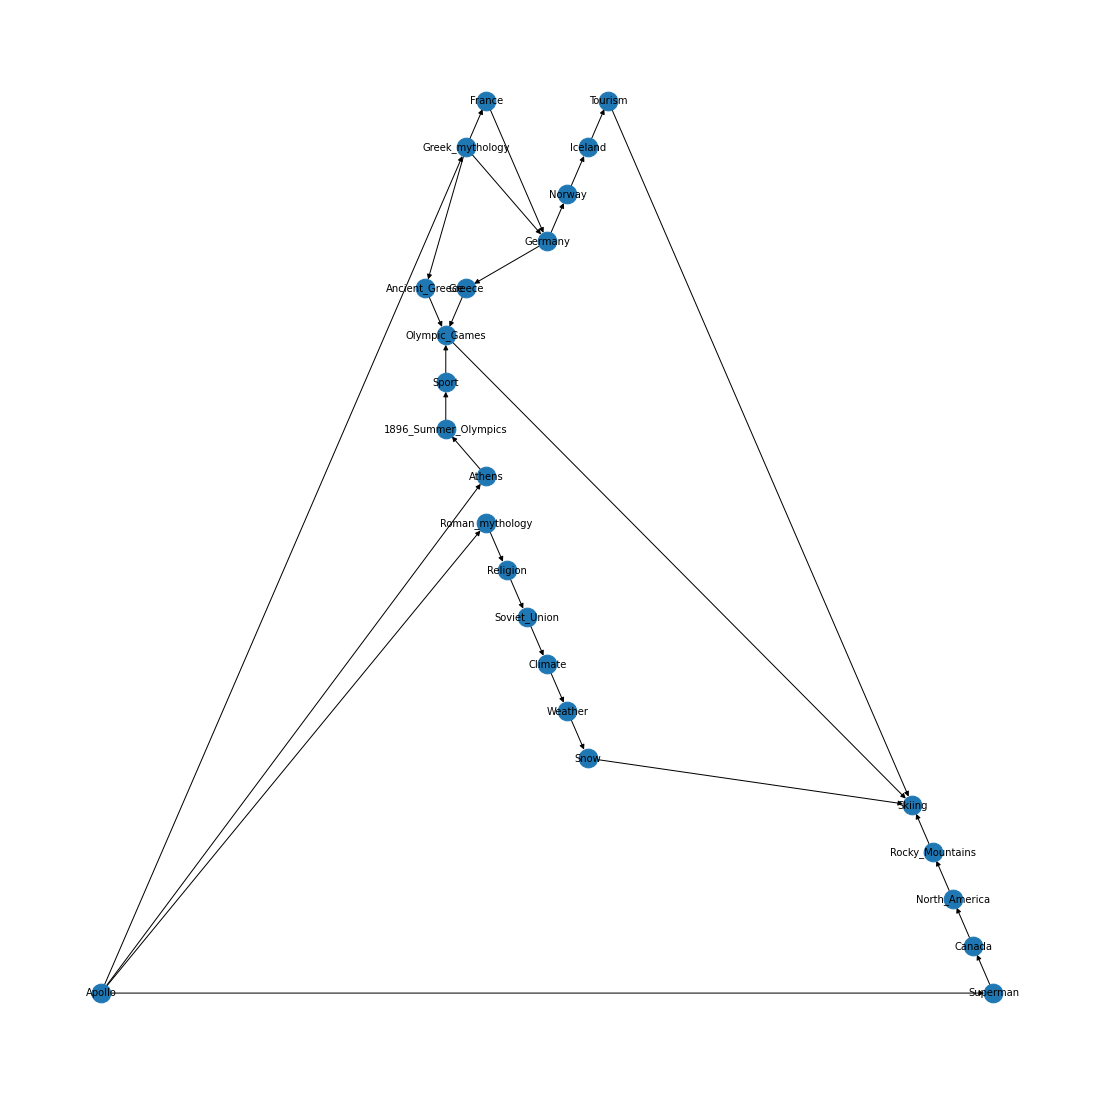

In [30]:
G = nx.DiGraph()
lst = []
for i in apollo_paths:
    G.add_nodes_from(i)
for i in apollo_paths:
    for j in range(len(i)-1):
        lst.append((i[j],i[j+1]))
G.add_edges_from(lst)
fig = plt.figure(figsize=(15,15))
nx.draw(G, with_labels=True, font_size=10, node_size=350, pos=nx.layout.planar_layout(G))

In [31]:
fig.savefig("apollo_skiing.png")

In [32]:
apollo_skiing = "This is not an optimal representation, but it is fine. The planar layout makes it suitable for detecting circles in the data and ensures that everything is recognizable and readable, but ideally one would use a more linear layout that makes it easier to recognize the start and end of the graph. Even though one can identify all neighbors, it is not easy to see that all paths start at Apollo and end at Skiing."
with open("apollo_skiing.txt", "w", encoding="utf-8") as f:
    f.write(apollo_skiing)

## 2b) Classic link prediction metrics (4)

In this task you should compute different metrics for link prediction. Do not use functions from networkx. Assume the graph you work on is undirected.

Write the functions `Jaccard_link(A)`, `Adamic_Adar_link(A)` and `Katz_link(A, beta)`.
The parameter A is a binary adjancency matrix of an undirected network (2d-numpy array), beta is defined in the lecture. They all return a matrix with the corresponding scores for all the nodes in the network.


*Help for Katz:* Search/google for geometric series of matrices. Raise a ValueError if the provided `beta` is to large. Numpy can compute the inverse of matrices.

The package networkx contains the Zachary’s Karate Club graph. It also contains functions that compute these link scores. You can use it for testing.


In [33]:
import numpy as np
import networkx as nx

In [34]:
G = nx.karate_club_graph()
A_karate = np.array(nx.adjacency_matrix(G).todense(),dtype=bool)
A_karate

array([[False,  True,  True, ...,  True, False, False],
       [ True, False,  True, ..., False, False, False],
       [ True,  True, False, ..., False,  True, False],
       ...,
       [ True, False, False, ..., False,  True,  True],
       [False, False,  True, ...,  True, False,  True],
       [False, False, False, ...,  True,  True, False]])

### Jaccard (1)

In [35]:
def Jaccard_link(A):
    arr = np.zeros(A.shape)
    num_rows, num_cols = arr.shape
    for i in range(num_rows):
        for j in range(num_cols):
            if i != j:
                arr[i,j] = np.sum(A[i, :] & A[j,:]) / np.sum(A[i, :] | A[j,:])
    return arr

In [36]:
# example usage
Jaccard_karate = Jaccard_link(A_karate)
Jaccard_karate[:5,:5]
#array([[0.        , 0.38888889, 0.23809524, 0.29411765, 0.11764706],
#       [0.38888889, 0.        , 0.26666667, 0.36363636, 0.09090909],
#       [0.23809524, 0.26666667, 0.        , 0.33333333, 0.08333333],
#       [0.29411765, 0.36363636, 0.33333333, 0.        , 0.125     ],
#       [0.11764706, 0.09090909, 0.08333333, 0.125     , 0.        ]])



array([[0.        , 0.38888889, 0.23809524, 0.29411765, 0.11764706],
       [0.38888889, 0.        , 0.26666667, 0.36363636, 0.09090909],
       [0.23809524, 0.26666667, 0.        , 0.33333333, 0.08333333],
       [0.29411765, 0.36363636, 0.33333333, 0.        , 0.125     ],
       [0.11764706, 0.09090909, 0.08333333, 0.125     , 0.        ]])

### Adamic (1)

In [37]:
def Adamic_link(A):
    arr = np.zeros(A.shape)
    num_rows, num_cols = arr.shape
    for i in range(num_rows):
        for j in range(num_cols):
            if i != j:
                value = 0;
                for z in range(num_cols):
                    if A[i,z] and A[j,z]:
                        value += (1 / np.log(np.sum(A[z,:])))
                arr[i,j] = value
    return arr

In [38]:
Adamic_karate = Adamic_link(A_karate)
Adamic_karate[:5,:5]

#array([[0.        , 6.13071687, 2.97724763, 3.67479159, 1.63158675],
#       [6.13071687, 0.        , 2.26146684, 2.1376507 , 0.36067376],
#       [2.97724763, 2.26146684, 0.        , 2.15847583, 0.36067376],
#       [3.67479159, 2.1376507 , 2.15847583, 0.        , 0.36067376],
#       [1.63158675, 0.36067376, 0.36067376, 0.36067376, 0.        ]])

array([[0.        , 6.13071687, 2.97724763, 3.67479159, 1.63158675],
       [6.13071687, 0.        , 2.26146684, 2.1376507 , 0.36067376],
       [2.97724763, 2.26146684, 0.        , 2.15847583, 0.36067376],
       [3.67479159, 2.1376507 , 2.15847583, 0.        , 0.36067376],
       [1.63158675, 0.36067376, 0.36067376, 0.36067376, 0.        ]])

### Katz (2)

In [39]:
def Katz_link(A, beta):
    eigen_max = max(np.linalg.eig(A)[0])
    if beta >= 1/eigen_max: # networkx package
        raise ValueError(str(beta) + ' is too large!')
    eye = np.eye(len(A))
    return np.linalg.inv(eye - beta * A) - eye

In [40]:
Katz_1 = Katz_link(A_karate, 0.1)
Katz_1[:4, :4]

array([[0.2995883 , 0.27947083, 0.26738417, 0.24308784],
       [0.27947083, 0.16957825, 0.23088253, 0.21168037],
       [0.26738417, 0.23088253, 0.19102141, 0.21330788],
       [0.24308784, 0.21168037, 0.21330788, 0.11670563]])

In [41]:
Katz_1 = Katz_link(A_karate, 0.1)
Katz_1[:4, :4]
#array([[0.2995883 , 0.27947083, 0.26738417, 0.24308784],
#       [0.27947083, 0.16957825, 0.23088253, 0.21168037],
#       [0.26738417, 0.23088253, 0.19102141, 0.21330788],
#       [0.24308784, 0.21168037, 0.21330788, 0.11670563]]

array([[0.2995883 , 0.27947083, 0.26738417, 0.24308784],
       [0.27947083, 0.16957825, 0.23088253, 0.21168037],
       [0.26738417, 0.23088253, 0.19102141, 0.21330788],
       [0.24308784, 0.21168037, 0.21330788, 0.11670563]])

In [42]:
# example usage
Katz_2= Katz_link(A_karate, 0.05)
Katz_2[:4, :4]

#array([[0.0481492 , 0.07453951, 0.07010033, 0.06877411],
#       [0.07453951, 0.02739842, 0.06603451, 0.06493847],
#       [0.07010033, 0.06603451, 0.03005164, 0.06485171],
#       [0.06877411, 0.06493847, 0.06485171, 0.01874642]])

array([[0.0481492 , 0.07453951, 0.07010033, 0.06877411],
       [0.07453951, 0.02739842, 0.06603451, 0.06493847],
       [0.07010033, 0.06603451, 0.03005164, 0.06485171],
       [0.06877411, 0.06493847, 0.06485171, 0.01874642]])

## 2c) Evaluate link prediction with mean inverse rank (4)

To evaluate your link prediction we will use the mean inverse rank (sometimes also called mean reciprocal rank). The basic idea is that if you did a train/test split of the edges you rank the edges that are in the test set (and some set of random edges for comparison) according to the similarity score in descending order. Now for only the *test* edges you obtain the place at which each edge is in the ranking of edges. This is the rank = place+1 of the edge. You then calculate the mean of the inverse rank (1/rank) of all test edges.

You would expect that if your ranking metric is able to properly rank the "real" test edges above the random edges, then it is a good ranking metric. If you take the mean inverse rank instead of just the mean rank you give more weight to high rank edges and less weight to low rank edges. Instead of comparing against a random set of edges we use all edges that are not present in the original network to compare against.

Write a function `cross_val_mir(G, func, n_folds, random_state)` that computes the mean inverse ranks for function `func` assume that the function takes a binary adjacency matrix and no other parameter. G is an undirected networkx graph. Use n_folds cross validation on the edge set (default for n should be 10). Use np.array_split to split the edges in G into the n chunks. Return a list of mean inverse ranks. The i-th element of the list corresponds to leaving the i-th chunk of edges out for testing.


We treat edges that have equal score as occupying 1 rank. i.e.
```
edges_to_score = [(1,2) : 0.5, (2,3) : 0.5, (4,5) : 0.24, (1,6) : 0.2]
# implies
edges_to_rank = [(1,2) : 1, (2,3) : 1, (4,5) : 2, (1,6) : 3]
```


In [43]:
from typing import List

In [44]:
import numpy as np

def cross_val_mir(G_in : nx.Graph, func, n_folds=10, random_state=4) -> List:
    edges = list(G_in.edges)
    np.random.seed(random_state)
    np.random.shuffle(edges)
    edge_chunks = np.array_split(edges, n_folds)
    # use the chunks that are defined above as the chunks for train test split
    
    res = []

    for test_elem in range(n_folds):
        test = edge_chunks[test_elem]
        train = []
        for elem in range(n_folds):
            if(elem != test_elem):
                train.append(edge_chunks[elem])
        
        adja_mat = np.zeros((G_in.number_of_nodes(), G_in.number_of_nodes()))
        for elem in train:
            adja_mat[elem[:,0], elem[:,1]] = 1
            adja_mat[elem[:,1], elem[:,0]] = 1
        
        link_mat = func(adja_mat.astype(bool))
    
        for elem in train:
            for edge in elem:
                link_mat[tuple(edge)] = 0
                link_mat[tuple(edge[::-1])] = 0
         
        rank_mat = np.zeros((G_in.number_of_nodes(), G_in.number_of_nodes()), int)
        max_value = np.amax(link_mat) + 1
        rank = 1
        while link_mat[link_mat < max_value].size:
            max_value = np.amax(link_mat[link_mat < max_value])
            indices = np.where(link_mat == max_value)
            for index in range(len(indices[0])):
                rank_mat[indices[0][index], indices[1][index]] = rank
            rank += 1
        
        res.append((1/(rank_mat[test[:,0], test[:,1]])).mean())
        
        #val = dict()
        #for i, k in test:
        #    val[(i, k)] = rank_mat[i, k]
        #print(test_elem, val)

    return res

In [45]:
cross_val_mir(nx.karate_club_graph(), Adamic_link)

# heldout edges and the rank obtained for them for validation round i
# 0 {(15, 33): 37, (26, 33): 29, (23, 32): 20, (15, 32): 37, (0, 21): 33, (2, 8): 27, (30, 33): 19, (2, 3): 3}
# 1 {(2, 27): 35, (0, 5): 23, (1, 13): 13, (28, 33): 30, (8, 33): 18, (0, 6): 23, (5, 6): 12, (14, 33): 33}
# 2 {(8, 30): 20, (1, 17): 26, (0, 12): 23, (0, 19): 24, (0, 8): 25, (0, 7): 8, (26, 29): 27, (24, 31): 16}
# 3 {(0, 13): 10, (5, 16): 31, (1, 21): 36, (1, 7): 24, (25, 31): 26, (0, 17): 33, (1, 2): 9, (2, 9): 38}
# 4 {(20, 33): 24, (2, 7): 7, (4, 6): 25, (1, 3): 4, (2, 32): 22, (3, 13): 17, (0, 31): 27, (23, 29): 19}
# 5 {(2, 13): 9, (13, 33): 34, (3, 12): 33, (23, 33): 5, (6, 16): 27, (3, 7): 13, (1, 30): 34, (18, 33): 31}
# 6 {(0, 10): 10, (2, 28): 32, (32, 33): 1, (0, 3): 2, (20, 32): 32, (24, 27): 32, (29, 32): 27, (22, 33): 32}
# 7 {(1, 19): 38, (27, 33): 31, (0, 1): 1, (0, 4): 4, (19, 33): 38, (8, 32): 11, (24, 25): 32, (5, 10): 36}
# 8 {(9, 33): 29, (30, 32): 15, (4, 10): 28, (23, 25): 29, (31, 32): 29, (31, 33): 17, (23, 27): 27}
# 9 {(0, 11): 30, (18, 32): 29, (29, 33): 4, (0, 2): 2, (28, 31): 29, (22, 32): 29, (14, 32): 29}


#output
#[0.07398022, 0.04937203, 0.05476794, 0.05098675, 0.08355881,
#       0.06830698, 0.22025463, 0.18560331, 0.04309854, 0.1316092 ]

[0.0739802240369391,
 0.049372034969861055,
 0.05476793787935092,
 0.050986747288742196,
 0.08355881254681563,
 0.06830698116276863,
 0.22025462962962963,
 0.18560331401879576,
 0.04309854209883187,
 0.13160919540229882]

In [46]:
cross_val_mir(nx.karate_club_graph(), Jaccard_link)

# heldout edges and the rank obtained for them for validation round i
# 0 {(15, 33): 38, (26, 33): 33, (23, 32): 19, (15, 32): 38, (0, 21): 34, (2, 8): 17, (30, 33): 24, (2, 3): 7}
# 1 {(2, 27): 31, (0, 5): 27, (1, 13): 7, (28, 33): 27, (8, 33): 19, (0, 6): 27, (5, 6): 7, (14, 33): 26}
# 2 {(8, 30): 5, (1, 17): 19, (0, 12): 23, (0, 19): 24, (0, 8): 26, (0, 7): 10, (26, 29): 8, (24, 31): 14}
# 3 {(0, 13): 14, (5, 16): 7, (1, 21): 16, (1, 7): 9, (25, 31): 16, (0, 17): 28, (1, 2): 10, (2, 9): 33}
# 4 {(20, 33): 28, (2, 7): 6, (4, 6): 11, (1, 3): 7, (2, 32): 30, (3, 13): 7, (0, 31): 32, (23, 29): 5}
# 5 {(2, 13): 7, (13, 33): 34, (3, 12): 10, (23, 33): 13, (6, 16): 7, (3, 7): 2, (1, 30): 34, (18, 33): 27}
# 6 {(0, 10): 23, (2, 28): 34, (32, 33): 8, (0, 3): 11, (20, 32): 34, (24, 27): 34, (29, 32): 27, (22, 33): 34}
# 7 {(1, 19): 32, (27, 33): 30, (0, 1): 5, (0, 4): 17, (19, 33): 32, (8, 32): 10, (24, 25): 7, (5, 10): 10}
# 8 {(9, 33): 31, (30, 32): 14, (4, 10): 8, (23, 25): 31, (31, 32): 31, (31, 33): 29, (23, 27): 13}
# 9 {(0, 11): 34, (18, 32): 25, (29, 33): 18, (0, 2): 13, (28, 31): 19, (22, 32): 25, (14, 32): 25}



#[0.05104066, 0.06502207, 0.08408333, 0.07705177, 0.10544846,
#       0.13231224, 0.05175893, 0.08718925, 0.05780123, 0.04778885]

[0.051040661479902966,
 0.0650220723438041,
 0.08408332704671378,
 0.07705176767676766,
 0.1054484577922078,
 0.13231224113577056,
 0.051758930954902825,
 0.08718925070028011,
 0.057801228645817875,
 0.04778885373312618]